# Time Series & Classification


Accuracy: 0.529, Precision: 0.539, Recall: 0.833, F1: 0.655


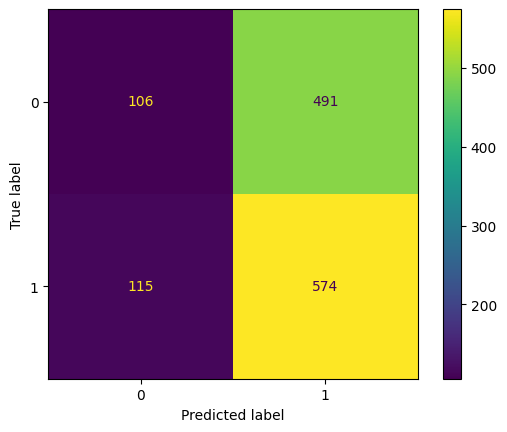

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# 2. Load dataset
DATA_IN = Path("../data/processed/ko_cleaned.parquet")
df = pd.read_parquet(DATA_IN).copy()

# 3. Create features
df["lag1"] = df["daily_ret"].shift(1)
df["rolling_mean_5d"] = df["daily_ret"].rolling(5).mean()
df["volatility_21d"] = df["daily_ret"].rolling(21).std()

# 4. Target: next-day direction
df["y_up"] = (df["daily_ret"].shift(-1) > 0).astype(int)

# 5. Drop NAs
df = df.dropna()

# 6. Features / Target
X = df[["lag1", "rolling_mean_5d", "volatility_21d"]]
y = df["y_up"]

# 7. Time-aware split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 8. Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

# 9. Fit model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# 10. Evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

# 11. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

- What worked?

The pipeline ran successfully with lag and rolling features, and the model was able to capture some predictive signal.

Recall is relatively high (0.833), meaning the model correctly identifies most of the days when returns go up. This could be useful if the goal is to avoid missing upward movements.

- Where might assumptions fail?

Accuracy is close to random guessing (0.529), suggesting the model has limited overall predictive power.

Precision is low (0.539), meaning many of the "up" predictions are false alarms. This is a risk if the strategy requires avoiding false positives.

Financial time series are noisy and may not follow stable linear relationships, so a simple logistic regression may be too weak to capture complex dynamics.

Features may not provide enough information — the model often defaults to predicting "up".

- How would you extend features or model?

Add more engineered features: e.g., 10-day momentum, moving averages (short vs long), RSI, or macroeconomic indicators.

Try alternative models that handle non-linearities better, such as Random Forests, Gradient Boosted Trees, or even recurrent neural networks (RNNs).

Evaluate with walk-forward validation instead of a single split to test robustness.

Adjust decision thresholds if recall vs precision trade-off is more important for the use case.